# **Human Speech to Sign Language**

The project aims to translate human speech into sign language. It involves processing the user's spoken input into text, which is subsequently transformed into sign language and presented as an image. This visual representation of the input allows the user to comprehend the translated sign language output, facilitating their understanding of how to convey their speech in sign language form.

# Collecting the data

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle

# copying api file
!cp kaggle.json ~/.kaggle/
# modding permission
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d risangbaskoro/wlasl-processed

100% 4.81G/4.82G [01:02<00:00, 101MB/s] 
100% 4.82G/4.82G [01:02<00:00, 83.4MB/s]


In [ ]:
!unzip wlasl-processed.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: videos/43596.mp4        
  inflating: videos/43598.mp4        
  inflating: videos/43599.mp4        
  inflating: videos/43671.mp4        
  inflating: videos/43672.mp4        
  inflating: videos/43674.mp4        
  inflating: videos/43677.mp4        
  inflating: videos/43679.mp4        
  inflating: videos/43680.mp4        
  inflating: videos/43681.mp4        
  inflating: videos/43682.mp4        
  inflating: videos/43684.mp4        
  inflating: videos/43689.mp4        
  inflating: videos/43697.mp4        
  inflating: videos/43698.mp4        
  inflating: videos/43700.mp4        
  inflating: videos/43703.mp4        
  inflating: videos/43726.mp4        
  inflating: videos/43727.mp4        
  inflating: videos/43729.mp4        
  inflating: videos/43730.mp4        
  inflating: videos/43733.mp4        
  inflating: videos/43800.mp4        
  inflating: videos/43801.mp4        
  inflating: videos/43802.mp4

In [ ]:
# import os
# os.environ['KAGGLE_CONFIG_DIR']="/content/drive/MyDrive/kaggle"
# %cd "/content/drive/MyDrive/kaggle"

In [ ]:
# import zipfile

# zip_path = '/content/drive/MyDrive/kaggle/wlasl-processed.zip'  # Replace with the path to your ZIP file

# # Extract the contents of the ZIP file to the current directory
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall('/content/')

In [ ]:
# import os
# os.environ['KAGGLE_CONFIG_DIR']="/content/drive/MyDrive/kaggle"
# %cd "/content/drive/MyDrive/kaggle"

In [ ]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.4 MB/s eta 0:00:00


In [ ]:
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Libraries for display and interaction:
from IPython.display import HTML, Audio, IFrame, display
from IPython.display import Video
from IPython.display import YouTubeVideo

# Libraries for audio processing:
import librosa
from scipy.io.wavfile import read as wav_read

# Libraries for data processing:
import numpy as np
import pandas as pd

# Libraries for file manipulation:
from pathlib import Path
import os

# Libraries for video processing:
from moviepy.editor import *

# Libraries for text processing:
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer

# For signal processing and visualization:
import matplotlib.pyplot as plt
from librosa.core import resample, to_mono
from tqdm import tqdm_notebook as tqdm

# For audio processing:
import soundfile as sf

from google.colab.output import eval_js
from base64 import b64decode
import io
import ffmpeg
import json
from collections import Counter

# Additional components for handling noise:
from scipy.io import wavfile
import argparse
from glob import glob
from tqdm import tqdm
import librosa.display

In [ ]:
#Kode javascript untuk memberikan GUI untuk merekam audio.
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

#  fungsi yang digunakan untuk merekam audio menggunakan kode JavaScript yang telah diberikan
# sebelumnya, dan mengonversinya menjadi format file audio WAV
def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data") #Mengambil data audio hasil perekaman
  binary = b64decode(data.split(',')[1]) #Mendekode data base64

  #  ffmpeg untuk mengonversi audio dalam bentuk binary menjadi format WAV
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )

  # Mengirim data audio dalam bentuk binary sebagai input ke proses ffmpeg dan
  # mendapatkan output WAV serta pesan kesalahan jika ada.
  output, err = process.communicate(input=binary)

  # Menghitung ukuran chunk RIFF audio WAV yang akan digunakan untuk memodifikasi header file WAV.
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  # Menggunakan library librosa untuk memuat audio WAV yang telah dimodifikasi
  # menjadi bentuk array audio dan mendapatkan nilai sample rate (sr).
  audio, sr = librosa.load(io.BytesIO(riff))

  return audio, sr

In [ ]:
# Getting the audio dengan memanggil fungsi sebelumnnya.
audio, sr = get_audio()

In [ ]:
# audio, sr = librosa.load('/content/Recording (4).m4a', sr = 16000)

In [ ]:
# Menampilkan audio nya dengan library Audio
Audio(audio, rate=sr)

In [ ]:
print(audio)

[-2.2073707e-14  2.7666305e-14 -3.9132429e-13 ... -3.6296778e-04
  1.4599964e-04  1.6494514e-04]


In [ ]:
sf.write('testing.wav', audio, 16000)

In [ ]:
sr = 16000

# **NOISE CANCELATION**


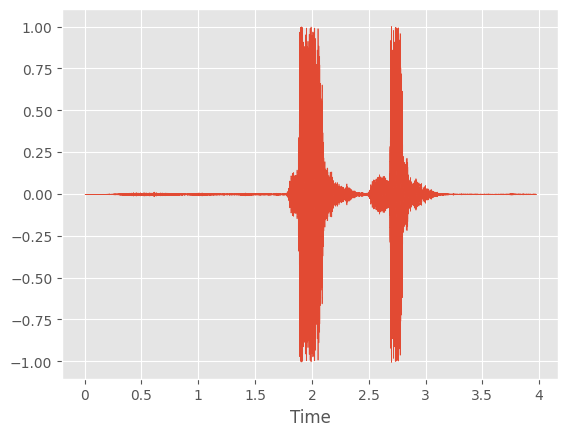

In [ ]:
librosa.display.waveshow(audio, sr=sr)
Audio(audio, rate=sr)

In [ ]:
# membuat sebuah "envelope" atau amplop dari sinyal audio. Amplop adalah representasi dari nilai
# amplitudo maksimum dalam suatu jendela waktu tertentu dari sinyal audio.
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/20),min_periods=1,center=True).max()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask, y_mean

In [ ]:
# melakukan proses downsampling pada sinyal audio menjadi sample rate (sr) yang ditentukan.
def downsample_mono(path, sr):
    rate, wav = wavfile.read(path)
    wav = wav.astype(np.float32, order='F')
    try:
        tmp = wav.shape[1]
        wav = to_mono(wav.T)
    except:
        pass
    wav = resample(wav, orig_sr=rate, target_sr=sr)
    wav = wav.astype(np.int16)
    return sr, wav

# tujuan untuk memeriksa keberadaan sebuah direktori pada path yang diberikan.
def check_dir(path):
    if os.path.exists(path) is False:
        os.mkdir(path)

#  digunakan untuk melakukan pengujian terhadap ambang batas tertentu pada
# sinyal audio dan menampilkan hasilnya dalam bentuk plot dan audio.
def test_threshold(args):
    src_root = args.src_root
    wav_paths = str(src_root)

    rate, wav = downsample_mono(wav_paths, args.sr)
    mask, env = envelope(wav, rate, threshold=args.threshold)
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    plt.style.use('ggplot')
    plt.title('Signal Envelope, Threshold = {}'.format(str(args.threshold)))
    plt.figure(figsize=(16,10))
    ax1.plot(wav, color='g', label='original')
    ax1.set_title('Original Audio from Tape Recorder',fontsize=16)
    ax2.plot(env, color='y', label='envelope')
    ax2.plot(wav[mask], color='c', label='keep')
    ax2.plot(wav[np.logical_not(mask)], color='r', label='remove')
    ax2.legend(loc='best',fontsize=16)
    ax2.set_title('Processed Audio',fontsize=16)
    plt.show()
    print("Original- Tape Recoder Audio")
    display(Audio(wav, rate=rate))
    print("Noise(removed)- Red")
    display(Audio(wav[np.logical_not(mask)], rate=sr))
    print("Pure Sound- Blue")
    display(Audio(wav[mask], rate=rate))

    return wav[mask], rate

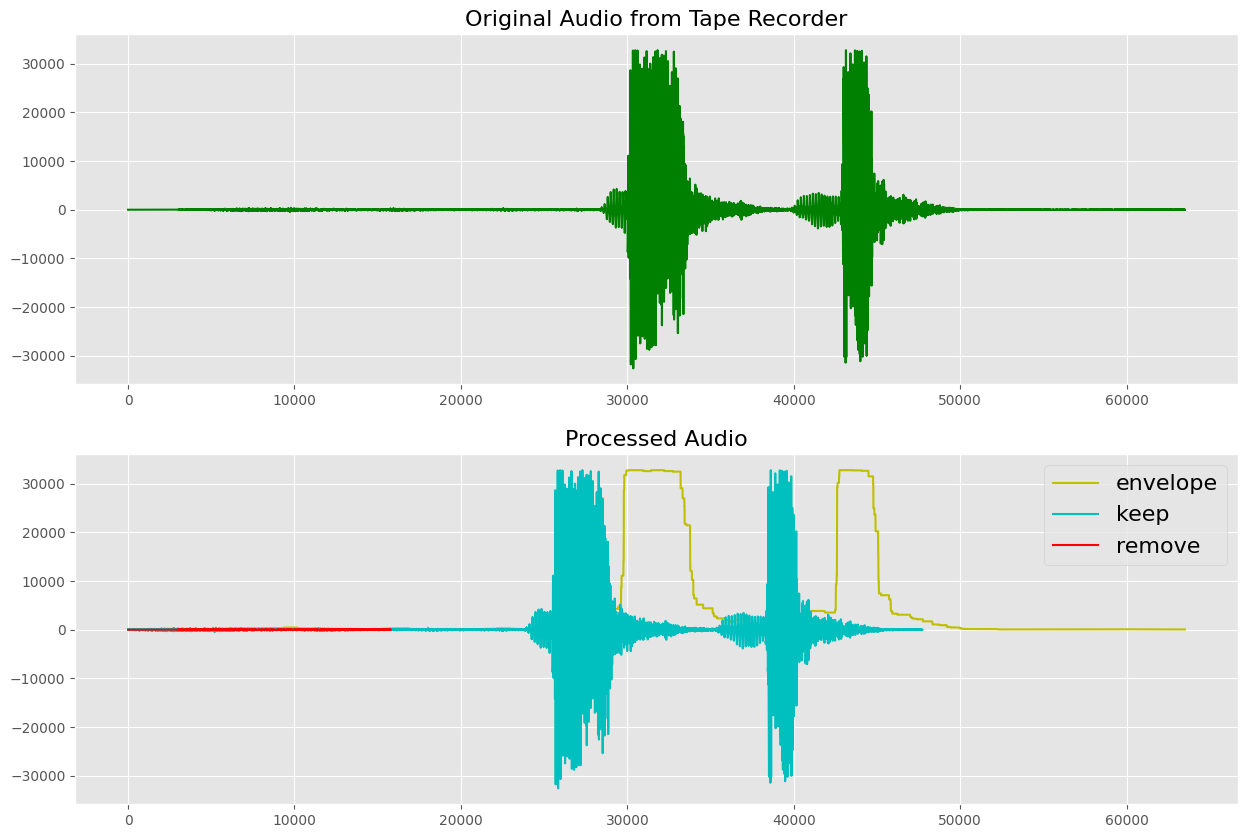

<Figure size 1600x1000 with 0 Axes>

Original- Tape Recoder Audio


Noise(removed)- Red


Pure Sound- Blue


In [ ]:
# 'argparse' untuk mengatur argumen yang digunakan dalam proses pembersihan data audio.
parser = argparse.ArgumentParser(description='Cleaning audio data')
parser.add_argument('--src_root', type=str, default='testing.wav')
parser.add_argument('--dst_root', type=str, default='clean')
parser.add_argument('--delta_time', '-dt', type=float, default=1.0)
parser.add_argument('--sr', type=int, default=16000)
parser.add_argument('--threshold', type=str, default=100) #threshold = 100
args, _ = parser.parse_known_args()
# argumen yang didefinisikan dalam parser akan diekstraksi dari baris perintah saat kode dieksekusi.

mask, rate = test_threshold(args)

# **Pre-Trained Model**

In [ ]:
# menggunakan model dan tokenizer dari library Hugging Face's Transformers
# untuk pemrosesan audio menggunakan model Wav2Vec2.
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
audio, sr = librosa.load('testing.wav')
# untuk mendapat nilai audo dan sr yang dapat untuk analsisi ataupun visualisasi

In [ ]:
Audio(audio, rate=22050)

In [ ]:
input_values = tokenizer(mask, return_tensors = "pt").input_values
# Melakukan tokenizer, sehingga mengubah mask menjadi bentuk yang dapat diproses oleh Wav2Vec2

In [ ]:
# keluaran logit dari model Wav2Vec2 setelah melakukan pemrosesan pada tensor input.
logits = model(input_values).logits

In [ ]:
prediction = torch.argmax(logits, dim = -1)
# prediksi terbaik dari model berdasarkan tensor logits

In [ ]:
transcription = tokenizer.batch_decode(prediction)[0]
# untuk mendekode prediksi yang dihasilkan sebelumnya menjadi teks transkripsi

# **TEXT OUTPUT**

In [ ]:
print(transcription)
# menampilkan hasilnya.

BLACK DOLL


In [ ]:
main_path = '/kaggle/input/wlasl-processed/'
wlas_df = pd.read_json('/content/WLASL_v0.3.json')

In [ ]:
def parse_json(): #converts the json file into a pandas datatype


    jsonpath = "/content/WLASL_v0.3.json"#json path

    #open json file as list of dictionaries
    with open(jsonpath) as data_file:
        data = json.load(data_file)

    header = ["gloss"]
    datakey = data[0]["instances"][0].keys() #create the column heads

    for h in datakey:
        header.append(h)


    df = pd.DataFrame(columns=header,dtype = object)#create an empty dataframe

    gloss_list = [d["gloss"] for d in data] #get list of glosses

    #iterate every gloss in the list and apend every video of that gloss
    for i in range(len(gloss_list)):
        gloss = gloss_list[i]
        instances = data[i]["instances"] #list of instances
        for j in range(len(instances)): #iterate over every instance
            entry = instances[j]
            entry["gloss"] = gloss
            df = df.append(entry,ignore_index=True)
    return (df, gloss_list)

#uncomment the following if json has not been parsed
df, gloss_list,  = parse_json()

Streaming output truncated to the last 5000 lines.
  df = df.append(entry,ignore_index=True)

  df = df.append(entry,ignore_index=True)

  df = df.append(entry,ignore_index=True)

  df = df.append(entry,ignore_index=True)

  df = df.append(entry,ignore_index=True)

  df = df.append(entry,ignore_index=True)

  df = df.append(entry,ignore_index=True)

  df = df.append(entry,ignore_index=True)

  df = df.append(entry,ignore_index=True)

  df = df.append(entry,ignore_index=True)

  df = df.append(entry,ignore_index=True)

  df = df.append(entry,ignore_index=True)

  df = df.append(entry,ignore_index=True)

  df = df.append(entry,ignore_index=True)

  df = df.append(entry,ignore_index=True)

  df = df.append(entry,ignore_index=True)

  df = df.append(entry,ignore_index=True)

  df = df.append(entry,ignore_index=True)

  df = df.append(entry,ignore_index=True)

  df = df.append(entry,ignore_index=True)

  df = df.append(entry,ignore_index=True)

  df = df.append(entry,ignore_index=True)

  d

In [ ]:
df

,gloss,bbox,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id
0,book,"[385, 37, 885, 720]",25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241
1,book,"[190, 25, 489, 370]",25,-1,1,1,90,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,65225
2,book,"[262, 1, 652, 480]",25,-1,1,2,110,valencia-asl,train,https://www.youtube.com/watch?v=0UsjUE-TXns,0,68011
3,book,"[123, 19, 516, 358]",25,60,1,3,113,lillybauer,train,https://www.youtube.com/watch?v=1QOYOZ3g-aY,0,68208
4,book,"[95, 0, 1180, 720]",25,-1,1,4,109,valencia-asl,train,https://www.youtube.com/watch?v=aGtIHKEdCds,0,68012
...,...,...,...,...,...,...,...,...,...,...,...,...
21078,whistle,"[76, 17, 236, 240]",25,-1,1,2,2,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/9...,0,63186
21079,whistle,"[3, 0, 320, 240]",25,-1,1,3,14,handspeak,train,https://www.handspeak.com/word/w/whistle.mp4,0,63187
21080,whistle,"[68, 14, 212, 192]",25,-1,1,4,11,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/9/9961.mp4,0,63188
21081,whistle,"[18, 4, 228, 240]",25,-1,1,5,84,aslpro,train,http://www.aslpro.com/main/w/whistle.swf,0,63189


# **English to WLASL**

In [ ]:
raw_vid_path = "/content/videos"#path of the raw video folder

vid_paths = os.listdir(raw_vid_path)


#remove video clips that are not integers and remove file extension
#vid_paths = [Path(path).stem for path in vid_paths if isdigit(Path(path).stem)]
vid_paths = [Path(path).stem for path in vid_paths]

vid_id = pd.DataFrame(vid_paths,columns=["video_id"],dtype=object)#create an empty dataframe

#get intersection
clean_df = pd.merge(vid_id,df,how="inner",on=["video_id"])

In [ ]:
data = df['gloss'].values

In [ ]:
temp = Counter(data)

#all the class in our dataset
print(temp.keys())

print(len(temp.keys()))


dict_keys(['book', 'drink', 'computer', 'before', 'chair', 'go', 'clothes', 'who', 'candy', 'cousin', 'deaf', 'fine', 'help', 'no', 'thin', 'walk', 'year', 'yes', 'all', 'black', 'cool', 'finish', 'hot', 'like', 'many', 'mother', 'now', 'orange', 'table', 'thanksgiving', 'what', 'woman', 'bed', 'blue', 'bowling', 'can', 'dog', 'family', 'fish', 'graduate', 'hat', 'hearing', 'kiss', 'language', 'later', 'man', 'shirt', 'study', 'tall', 'white', 'wrong', 'accident', 'apple', 'bird', 'change', 'color', 'corn', 'cow', 'dance', 'dark', 'doctor', 'eat', 'enjoy', 'forget', 'give', 'last', 'meet', 'pink', 'pizza', 'play', 'school', 'secretary', 'short', 'time', 'want', 'work', 'africa', 'basketball', 'birthday', 'brown', 'but', 'cheat', 'city', 'cook', 'decide', 'full', 'how', 'jacket', 'letter', 'medicine', 'need', 'paint', 'paper', 'pull', 'purple', 'right', 'same', 'son', 'tell', 'thursday', 'visit', 'wait', 'water', 'wife', 'yellow', 'backpack', 'bar', 'brother', 'cat', 'check', 'class', '

In [ ]:
search_word = transcription.lower().split(' ')
print(search_word)

['black', 'doll']


In [ ]:
data2 = df['signer_id'].values
temp2 = Counter(data2)

print(temp2.keys())
print(len(temp2.keys()))

dict_keys([118, 90, 110, 113, 109, 121, 49, 18, 31, 36, 59, 12, 14, 11, 5, 115, 94, 65, 44, 52, 6, 21, 20, 2, 10, 9, 38, 56, 72, 41, 4, 45, 32, 24, 46, 88, 13, 0, 25, 42, 111, 87, 93, 80, 39, 17, 89, 102, 112, 60, 35, 69, 16, 15, 47, 64, 83, 30, 3, 51, 92, 34, 100, 107, 28, 7, 68, 116, 99, 37, 8, 82, 97, 70, 19, 91, 67, 98, 106, 96, 63, 29, 26, 117, 66, 119, 54, 81, 101, 50, 103, 120, 95, 78, 55, 27, 108, 57, 53, 75, 86, 84, 62, 104, 58, 43, 74, 40, 77, 1, 33, 22, 105, 85, 79, 48, 73, 76, 23])
119


In [ ]:
data_pembicara = []

for i in temp2.keys() :
  temporary_only = []
  for index, j in enumerate(df.signer_id) :
    if i == j :
      temporary_only.append([df.gloss[index], df.url[index]])
  data_pembicara.append([i, temporary_only])

Melakukan penyimpnanan data pembicara dari link video sehingga nantinya video yang dihasilkan dari orang yang sama.

In [ ]:
data_pembicara

[[118,
  [['book', 'http://aslbricks.org/New/ASL-Videos/book.mp4'],
   ['go', 'http://aslbricks.org/New/ASL-Videos/go.mp4'],
   ['who', 'http://aslbricks.org/New/ASL-Videos/who.mp4'],
   ['no', 'http://aslbricks.org/New/ASL-Videos/no.mp4'],
   ['yes', 'http://aslbricks.org/New/ASL-Videos/yes.mp4'],
   ['black', 'http://aslbricks.org/New/ASL-Videos/black.mp4'],
   ['hot', 'http://aslbricks.org/New/ASL-Videos/hot.mp4'],
   ['like', 'http://aslbricks.org/New/ASL-Videos/like.mp4'],
   ['many', 'http://aslbricks.org/New/ASL-Videos/many.mp4'],
   ['now', 'http://aslbricks.org/New/ASL-Videos/now.mp4'],
   ['orange', 'http://aslbricks.org/New/ASL-Videos/orange.mp4'],
   ['what', 'http://aslbricks.org/New/ASL-Videos/what.mp4'],
   ['blue', 'http://aslbricks.org/New/ASL-Videos/blue.mp4'],
   ['can', 'http://aslbricks.org/New/ASL-Videos/can.mp4'],
   ['dog', 'http://aslbricks.org/New/ASL-Videos/dog.mp4'],
   ['white', 'http://aslbricks.org/New/ASL-Videos/white.mp4'],
   ['cow', 'http://aslbricks.

In [ ]:
#yang baru
vid_final = []
len_target = len(search_word)
x = True

# for word in search_word :
#   matching_videos = []
for i, j in data_pembicara :
  if x == False :
    break

  len_counter = 0
  matching_videos = []
  for x, y in j :
    if x in search_word :
      if y.endswith('.mp4'):
        matching_videos.append(y)
        len_counter += 1

    if len_counter == len_target :
      x = False

if x == False :
  vid_final.append(matching_videos)

In [ ]:
vid_final

[['http://www.aslsearch.com/signs/videos/black.mp4',
  'http://www.aslsearch.com/signs/videos/doll.mp4']]

In [ ]:
import json
import os

# search_word=['black', 'dog']

#kalau tidak ada pembicara yang sama dalam kata yang mau dicari, maka pembicara akan digabung dengan codingan dibawah ini
if x == True:
  for word in search_word :
    matching_videos = []
    for index, glos in enumerate(df.gloss):
        if word in glos:
            matching_videos.append(df.url[index])

    mp4_videos = [url for url in matching_videos if url.endswith('.mp4')]
    vid_final.append(mp4_videos[0])


In [ ]:
mp4_videos = [url for url in vid_final]

print(mp4_videos)

[['http://www.aslsearch.com/signs/videos/black.mp4', 'http://www.aslsearch.com/signs/videos/doll.mp4']]


In [ ]:
%pip install moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Display WLASL**

Dilakukan video concate agar video tidak satu per satu tetapi langsung jadi 1 video penuh 1 kalimat.

In [ ]:
#video concate
def concatenate(video_clip_paths, output_path):
    clips = [VideoFileClip(c) for c in video_clip_paths]
    final_clip = concatenate_videoclips(clips)
    final_clip.write_videofile(output_path)

In [ ]:
concatenate(mp4_videos[0], '/content/result.mp4')

Moviepy - Building video /content/result.mp4.
MoviePy - Writing audio in resultTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/result.mp4



Moviepy - Done !
Moviepy - video ready /content/result.mp4


In [ ]:
output_path='/content/result.mp4'

In [ ]:
from IPython.display import HTML
from base64 import b64encode
def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

In [ ]:
play(output_path)

# **Result**

Projek ini menunjukkan hasil yang sangat menjanjikan setelah menerapkan pendekatan yang diusulkan, yaitu Pengenalan Audio Otomatis menggunakan Wav2Vec2 untuk mengubah ucapan manusia menjadi teks, dan kemudian mengonversi teks tersebut menjadi video dengan memanfaatkan dataset WLASL.